In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1234)

np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [2]:
from IPython.display import Image
from numpy.core.umath_tests import matrix_multiply as mm

In [3]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom

In [4]:
def neg_loglik(thetas, n, xs, zs):
    return -np.sum([binom(n, thetas[z]).logpmf(x) for (x, z) in zip(xs, zs)])

In [5]:
m = 10
theta_A = 0.8
theta_B = 0.3
theta_0 = [theta_A, theta_B]

coin_A = bernoulli(theta_A)
coin_B = bernoulli(theta_B)

xs = map(sum, [coin_A.rvs(m), coin_A.rvs(m), coin_B.rvs(m), coin_A.rvs(m), coin_B.rvs(m)])
zs = [0, 0, 1, 0, 1]

In [6]:
xs = np.array(xs)
xs

array([7.000, 9.000, 2.000, 6.000, 0.000])

In [7]:
ml_A = np.sum(xs[[0,1,3]])/(3.0*m)
ml_B = np.sum(xs[[2,4]])/(2.0*m)
ml_A, ml_B

(0.73333333333333328, 0.10000000000000001)

In [8]:
bnds = [(0,1), (0,1)]
minimize(neg_loglik, [0.5, 0.5], args=(m, xs, zs),
         bounds=bnds, method='tnc', options={'maxiter': 100})

     fun: 7.6552677541393193
     jac: array([-0.000, -0.000])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 17
     nit: 6
  status: 1
 success: True
       x: array([0.733, 0.100])

In [27]:
def em(xs, thetas, max_iter=100, tol=1e-6):
    """Expectation-maximization for coin sample problem."""

    ll_old = -np.infty
    for i in range(max_iter):
        ll = np.array([np.sum(xs * np.log(theta), axis=1) for theta in thetas])
        lik = np.exp(ll)
        ws = lik/lik.sum(0)
        vs = np.array([w[:, None] * xs for w in ws])
        thetas = np.array([v.sum(0)/v.sum() for v in vs])
        ll_new = np.sum([w*l for w, l in zip(ws, ll)])
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
    return i, thetas, ll_new

In [28]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

i, thetas, ll = em(xs, thetas)
print i
for theta in thetas:
    print theta
print ll

18
[0.797 0.203]
[0.520 0.480]
-29.868676155


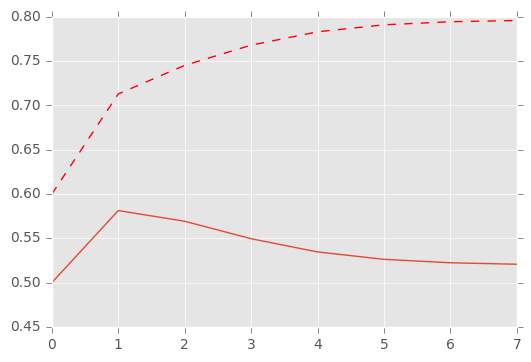

In [30]:
import numpy as np
import math
import matplotlib.pyplot as plt

#### E-M Coin Toss Example as given in the EM tutorial paper by Do and Batzoglou* #### 

def get_binomial_log_likelihood(obs,probs):
    """ Return the (log)likelihood of obs, given the probs"""
    # Binomial Distribution Log PDF
    # ln (pdf)      =             Binomial Coeff            *   product of probabilities
    # ln[f(x|n, p)] =               comb(N,k)               *   num_heads*ln(pH) + (N-num_heads) * ln(1-pH) 

    N = sum(obs);#number of trials  
    k = obs[0] # number of heads
    binomial_coeff = math.factorial(N) / (math.factorial(N-k) * math.factorial(k))
    prod_probs = obs[0]*math.log(probs[0]) + obs[1]*math.log(1-probs[0])
    log_lik = binomial_coeff + prod_probs

    return log_lik

# 1st:  Coin B, {HTTTHHTHTH}, 5H,5T
# 2nd:  Coin A, {HHHHTHHHHH}, 9H,1T
# 3rd:  Coin A, {HTHHHHHTHH}, 8H,2T
# 4th:  Coin B, {HTHTTTHHTT}, 4H,6T
# 5th:  Coin A, {THHHTHHHTH}, 7H,3T
# so, from MLE: pA(heads) = 0.80 and pB(heads)=0.45

# represent the experiments
head_counts = np.array([5,9,8,4,7])
tail_counts = 10-head_counts
experiments = zip(head_counts,tail_counts)

# initialise the pA(heads) and pB(heads)
pA_heads = np.zeros(100); pA_heads[0] = 0.60
pB_heads = np.zeros(100); pB_heads[0] = 0.50

# E-M begins!
delta = 0.001  
j = 0 # iteration counter
improvement = float('inf')
while (improvement>delta):
    expectation_A = np.zeros((len(experiments),2), dtype=float) 
    expectation_B = np.zeros((len(experiments),2), dtype=float)
    for i in range(0,len(experiments)):
        e = experiments[i] # i'th experiment
        ll_A = get_binomial_log_likelihood(e,np.array([pA_heads[j],1-pA_heads[j]])) # loglikelihood of e given coin A
        ll_B = get_binomial_log_likelihood(e,np.array([pB_heads[j],1-pB_heads[j]])) # loglikelihood of e given coin B

        weightA = math.exp(ll_A) / ( math.exp(ll_A) + math.exp(ll_B) ) # corresponding weight of A proportional to likelihood of A 
        weightB = math.exp(ll_B) / ( math.exp(ll_A) + math.exp(ll_B) ) # corresponding weight of B proportional to likelihood of B                            

        expectation_A[i] = np.dot(weightA, e) 
        expectation_B[i] = np.dot(weightB, e)

    pA_heads[j+1] = sum(expectation_A)[0] / sum(sum(expectation_A)); 
    pB_heads[j+1] = sum(expectation_B)[0] / sum(sum(expectation_B)); 

    improvement = max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - np.array([pA_heads[j],pB_heads[j]]) ))
    j = j+1

plt.figure();
plt.plot(range(0,j),pA_heads[0:j], 'r--')
plt.plot(range(0,j),pB_heads[0:j])
plt.show()